In [45]:
# data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
# data.info()

In [46]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import plotly.express as px 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [47]:
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, silhouette_score, accuracy_score, confusion_matrix, mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [48]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [49]:
data.duplicated().sum()
data.drop_duplicates(keep='first',subset=None,ignore_index=False,inplace=True)
data.duplicated().sum()

0

In [50]:
mis_col = data.isna().sum() * 100/len(data)
mis_col.sort_values(ascending=False)
# mis_col

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [51]:
orig_reg = data.region 

le = LabelEncoder()

data.region = le.fit_transform(data.region)
data.sex = le.fit_transform(data.sex)
data.smoker = le.fit_transform(data.smoker)

In [52]:
le_reg = data.region 

orireg_dic = np.unique(orig_reg)
lereg_dic = np.unique(le_reg)

reg_dic = dict(zip(orireg_dic,lereg_dic))
reg_dic


{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}

<AxesSubplot:title={'center':'Correlation Matrix'}>

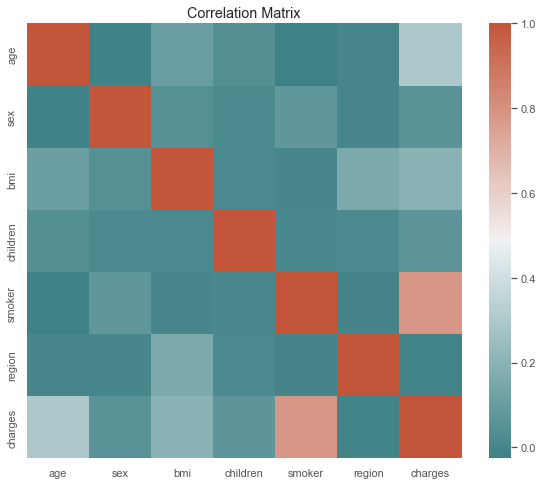

In [53]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,8))
ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(200,20, as_cmap=True), ax=ax, square=True)

In [54]:
y = data.charges 
x = data.drop(columns=['charges'])


In [55]:
scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x))
y = scaler.fit_transform(np.array(y).reshape(-1,1))


In [56]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42, test_size=0.2)

In [57]:
linreg = LinearRegression()

linreg.fit(x_train,y_train)

y_true = y_test 

y_pred = linreg.predict(x_test)

scr_r2 = r2_score(y_true,y_pred).round(3)
mse_scr = mean_squared_error(y_true,y_pred).round(3)

modperf = pd.DataFrame( 
    ( 
        'LinearRegression', scr_r2, mse_scr
    )
).transpose()

modperf.columns = ['Method', 'Test R2', 'Test Mse']

modperf

,Method,Test R2,Test Mse
0,LinearRegression,0.807,0.242


In [60]:
ranfor = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, criterion='squared_error')

ranfor.fit(x_train,y_train)

y_true = y_test 

y_pred = ranfor.predict(x_test)

r2_scr = r2_score(y_true,y_pred)
scr_mse = mean_squared_error(y_true,y_pred)

ranformod = pd.DataFrame( 
    ( 
        'RandomForestRegressor', r2_scr, scr_mse
    )
).transpose()

ranformod.columns = ['Test Method', 'R2 RanForest', 'MSE RanForest']

ranformod


C:\Users\amunv\AppData\Local\Temp\ipykernel_22112\1587707153.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ranfor.fit(x_train,y_train)


,Test Method,R2 RanForest,MSE RanForest
0,RandomForestRegressor,0.881938,0.148035
